<a href="https://colab.research.google.com/github/aus10powell/ml-engineer/blob/master/poizon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [7]:
%%capture
#!pip install wandb
from google.colab import drive
import tensorflow as tf
import keras


# Display/Utility
from IPython.display import Image, display
from tqdm import tqdm
import cv2
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger
import os



# ML
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


if tf.test.is_gpu_available():
  print('Using GPU')
else:
  print('Not using GPU')
  
  
drive.mount('/content/gdrive', force_remount=False)

##### Links
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Utility Functions

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
  


def classify_new_image(img_path = None):
  """Returns 1 for smoking; 0 for not smoking. Single image"""

  try:
    img = cv2.imread(img_path)
    img = cv2.resize(img,(image_size,image_size))
    img = np.reshape(img,[1,image_size,image_size,3])

    classes = model.predict_classes(img)
    return classes[0][0]
  except Exception as e:
    print(e)
    
def classify_image(img_path = None):
  """Returns 1 for smoking; 0 for not smoking. Single image"""

  try:
    img = cv2.imread(img_path)
    img = cv2.resize(img,(image_size,image_size))
    img = np.reshape(img,[1,image_size,image_size,3])

    classes = model.predict_classes(img)
    return classes
  except Exception as e:
    print(e)

In [ ]:
def count_jpg_files(folder_path):
    count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):
                count += 1

    return count

In [3]:
root_path = './gdrive/My Drive/poizon/'  # all images together: all_train120319
print(os.listdir(root_path))
classes = ['poizon','not_poizon']

train_path = root_path + 'split_data/train'
print(os.listdir(train_path))

validation_path = root_path + 'split_data/validation'
print('validation_path:',validation_path)

test_path = root_path + 'split_data/test'
print('test_path:',test_path)



# Iterate over the split directories to validate those paths
for path in [train_path,test_path,validation_path]:
  print(path)
  assert os.path.isdir(path)

import hashlib

def find_duplicate_files(folder):
    # Dictionary to store file hashes and their paths
    file_hashes = {}

    # Traverse through the folder and its subfolders
    for root, dirs, files in os.walk(folder):
        for filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, filename)

            # Calculate the MD5 hash of the file
            file_hash = hash_file(file_path)

            # Check if the file hash already exists
            if file_hash in file_hashes:
                # Duplicate file found
                print(f"Duplicate file found: {file_path}")
                print(f"Original file path: {file_hashes[file_hash]}")
                print()
            else:
                # Add the file hash and its path to the dictionary
                file_hashes[file_hash] = file_path

def hash_file(file_path):
    # Create a hash object
    hash_obj = hashlib.md5()

    # Open the file in binary mode
    with open(file_path, "rb") as file:
        # Read the file in chunks to avoid memory issues with large files
        for chunk in iter(lambda: file.read(4096), b""):
            # Update the hash object with the chunk
            hash_obj.update(chunk)

    # Get the hexadecimal representation of the hash
    file_hash = hash_obj.hexdigest()

    return file_hash

# Example usage
folder_path = root_path
find_duplicate_files(folder_path)


['split_data']
['not_poison', 'is_poison']
validation_path: ./gdrive/My Drive/poizon/split_data/validation
test_path: ./gdrive/My Drive/poizon/split_data/test
./gdrive/My Drive/poizon/split_data/train
./gdrive/My Drive/poizon/split_data/test
./gdrive/My Drive/poizon/split_data/validation


In [4]:
image_size = 299
batch_size = 4
num_classes = 2

import wandb
#wandb.api.api_key = "b146bd8bba49024b232861c1a54ded79f12c5078"
wandb.init(entity="aus10powell",project="PoizonTraining")
config = wandb.config
from keras import regularizers, optimizers
from tensorflow.python.keras import layers 
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from keras.models import Model



######################### From Scratch Model ###################################



import tensorflow as tf
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true) * (1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())

    return f1_score

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    recall = tp / (tp + fn + K.epsilon())
    return recall
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    return precision




# def get_model3(image_size):
#     config = wandb.config  # Config is a variable that holds and saves hyperparameters and inputs
#     config.learning_rate = 0.001
#     config.batch_size = batch_size
#     config.image_size = image_size
#     config.activation = 'relu'
#     config.loss = 'binary_crossentropy'
#     config.metrics = ['accuracy', f1,recall]

#     input_shape = (image_size, image_size, 3)
#     base_model = MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False)


#     model = Sequential()
#     model.add(base_model)
#     #model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dense(128, activation=config.activation))
#     model.add(Dense(2, activation='softmax'))
#     model.add(layers.Dropout(0.4))
#     # model.add(layers.Dense(64, activation=config.activation ))  # Add another dense layer
#     # model.add(layers.Dropout(0.4))  # Add dropout to the new dense layer
#     model.add(layers.Dense(16, activation=config.activation ))  # Add another dense layer
#     model.add(layers.Dropout(0.4))  # Add dropout to the new dense layer
#     model.add(layers.Dense(16, activation=config.activation))  # Add another dense layer
#     model.add(layers.Dropout(0.4))  # Add dropout to the new dense layer

#     model.add(layers.Dense(32, activation=config.activation ))  # Add another dense layer
#     model.add(layers.Dropout(0.4))  # Add dropout to the new dense layer
#     model.add(layers.Dense(1, activation='sigmoid'))

#     model.compile(loss=config.loss,
#                   optimizer=legacy.Adam(lr=config.learning_rate, decay=1e-5),
#                   metrics=[recall, f1]
#                   )

#     return model
def get_model3(image_size):
  config = wandb.config  # Config is a variable that holds and saves hyperparameters and inputs
  config.learning_rate = 0.001
  config.batch_size = batch_size
  config.image_size = image_size
  config.activation = 'relu'
  config.loss = 'binary_crossentropy'
  config.metrics = ['accuracy', f1,recall]
  config.dropout = 0.4

  base_model = MobileNetV3Small(input_shape=(image_size, image_size, 3), dropout_rate=0.3,weights=None,classes=2,include_top=True)

  model = Sequential()
  model.add(base_model)
  #model.add(layers.GlobalAveragePooling2D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = keras.optimizers.Adam(lr=0.1, decay=1e-6)
  
  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', f1,recall])
  
  return model


model = get_model3(image_size=image_size)


wandb: Currently logged in as: aus10powell. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# import os
# from PIL import Image

# def get_average_image_dimensions(root_folder):
#     total_width = 0
#     total_height = 0
#     total_images = 0

#     for root, dirs, files in os.walk(root_folder):
#         for file in files:
#             if file.lower().endswith(".jpg"):
#                 image_path = os.path.join(root, file)
#                 try:
#                     image = Image.open(image_path)
#                     width, height = image.size
#                     total_width += width
#                     total_height += height
#                     total_images += 1
#                 except (IOError, OSError):
#                     print(f"Failed to process image: {image_path}")

#     if total_images > 0:
#         average_width = total_width / total_images
#         average_height = total_height / total_images
#         return average_width, average_height
#     else:
#         return None

# root_folder = train_path
# average_dimensions = get_average_image_dimensions(root_folder)

# if average_dimensions is not None:
#     print(f"Average Image Dimensions: {average_dimensions[0]} x {average_dimensions[1]} pixels")
# else:
#     print("No JPEG images found in the subfolders.")


In [5]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./image_size,
      #   shear_range=0.2,
      zoom_range=[0.8, 1.2],
      # #brightness_range=[0.5, 1.5],
     rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True
)


# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = train_datagen
# ImageDataGenerator(
#         rescale=1./image_size,
#         shear_range=0.2,
#         zoom_range=0.2,
#       #brightness_range=[0,1],
#         rotation_range=45,
#         horizontal_flip=True,
#         vertical_flip=True
# )

test_datagen = ImageDataGenerator(
        rescale=1./image_size,
        shear_range=0.2,

        zoom_range=0.2,
    rotation_range=15,
        horizontal_flip=True,
        vertical_flip=True)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(image_size,image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        validation_path,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='categorical')



Found 833 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


## Training Model

In [ ]:
epochs = 10

val_steps = validation_generator.n // batch_size
print('val_steps',val_steps)


steps_per_epoch = train_generator.n // batch_size
print('steps_per_epoch',steps_per_epoch)

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        shuffle=True,
        validation_data=test_generator,
        validation_steps=val_steps,
    callbacks=[WandbMetricsLogger()])

val_steps 53
steps_per_epoch 208
Epoch 1/10
208/208 [==============================] - 161s 771ms/step - loss: 0.6931 - accuracy: 0.5000 - f1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
208/208 [==============================] - 171s 817ms/step - loss: 0.6931 - accuracy: 0.5000 - f1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
208/208 [==============================] - 163s 778ms/step - loss: 0.6931 - accuracy: 0.5000 - f1: 0.1405 - recall: 0.1719 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
208/208 [==============================] - 157s 752ms/step - loss: 0.6931 - accuracy: 0.5000 - f1: 0.1597 - recall: 0.1899 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
208/208 [==============================] - 167s 802m

KeyboardInterrupt: ignored

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the paths for the train data

train_poison_path = os.path.join(train_path, 'is_poison')
train_not_poison_path = os.path.join(train_path, 'not_poison')

# Define the input shape and number of classes
input_shape = (image_size, image_size, 3) # Adjust the input shape based on your image size
num_classes = 2


# Set the hyperparameters
batch_size = 16
epochs = 15

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)
import wandb
wandb.init(entity="aus10powell",project="PoizonTraining")
config = wandb.config
config = wandb.config
config.learning_rate = 0.05
config.dropout1 = 0.04
config.dropout_final = 0.04
config.input_shape = input_shape
config.batch_size = batch_size

# Build the model
#base_model = MobileNetV3Small(input_shape=input_shape, dropout_rate=0.3,include_top = False, weights="imagenet")

### Method 1
# model = Sequential()
# #model.add(base_model)
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# #model.add(Dropout(config.dropout1))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(config.dropout_final))
# model.add(Dense(num_classes, activation='softmax'))

### Method 
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(config.dropout_final))
model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
optimizer = optimizers.Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',recall,precision,f1])


# Train the model
history = model.fit(train_generator, epochs=epochs,validation_data=validation_generator,
    callbacks=[WandbMetricsLogger()])


Found 833 images belonging to 2 classes.


Epoch 1/15
28/53 [==============>...............] - ETA: 46s - loss: 4.9653 - accuracy: 0.8430 - recall: 0.4821 - precision: 0.4074 - f1: 0.4295

## Evaluation



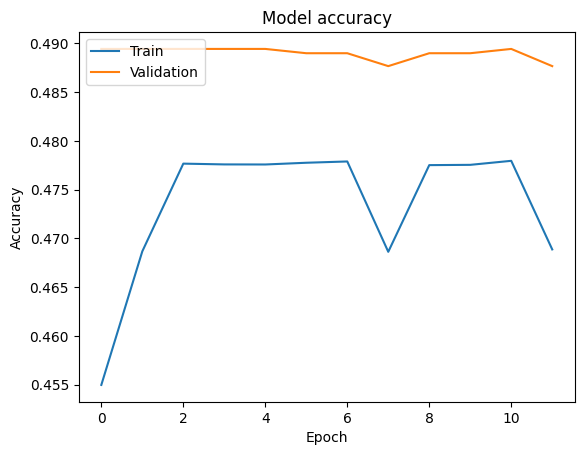

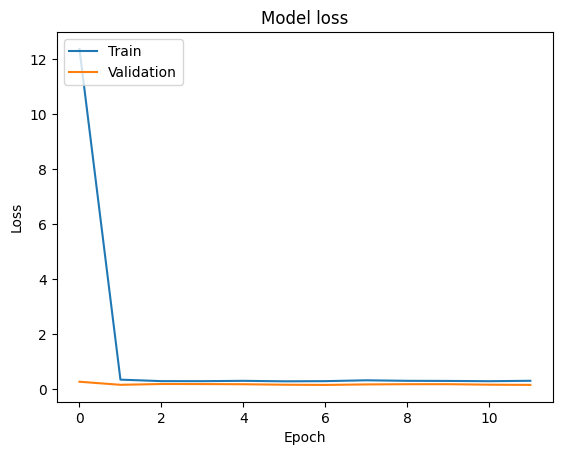

<ipython-input-9-d25893dd73a2>:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoreSeg = model.evaluate_generator(test_generator, use_multiprocessing=True)


Test Set Accuracy = 0.9629629850387573


In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

scoreSeg = model.evaluate_generator(test_generator, use_multiprocessing=True)
print("Test Set Accuracy =", scoreSeg[1])


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from keras.preprocessing import image

# Path to the directory containing the images
image_dir = os.path.join(root_path,"split_data","test")  # Replace with the actual path to your image directory

# List of subdirectories (class labels)
subdirectories = ['is_poison', 'not_poison']

# Randomly select a subdirectory
random_subdirectory = random.choice(subdirectories)

# Get a list of image file names in the selected subdirectory
subdirectory_path = os.path.join(image_dir, random_subdirectory)
image_files = os.listdir(subdirectory_path)

# Randomly select an image file
random_image_file = random.choice(image_files)

# Load and preprocess the randomly selected image
img_path = os.path.join(subdirectory_path, random_image_file)
img = Image.open(img_path)
#img = img.resize((image_size, image_size))
img = img.resize((150, 150))
x = np.array(img, dtype=np.float32)  # Convert image data to float
x = np.expand_dims(x, axis=0)
x /= 255.0
# # Make predictions

predictions = model.predict(x)
predicted_class = "poison" if predictions[0][0] >= 0.5 else "not_poison"
correct_class = random_subdirectory
result = "CORRECT" if correct_class == predicted_class else "WRONG"
# Display the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"{result} Predicted: {predicted_class}, True: {correct_class} {predictions}")
plt.show()


ValueError: ignored

0.030919993

### Experimentation

In [ ]:
os.listdir(os.path.join(train_path,"is_poison"))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def create_unet_model(input_shape):
    # Encoder (MobileNetV2)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)
    encoder_layers = [base_model.get_layer(name).output for name in ['block_6_expand_relu', 'block_13_expand_relu']]
    encoder_output = Concatenate(axis=-1)(encoder_layers)  # Concatenate along the channel axis

    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(bottleneck)

    # Expanding Path (Decoder)
    decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    decoder = Concatenate(axis=-1)([decoder, base_model.get_layer('block_6_expand_relu').output])
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = Concatenate(axis=-1)([decoder, base_model.get_layer('block_3_expand_relu').output])
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2DTranspose(3, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=decoder)
    model.compile(optimizer='adam', loss='mse')

    return model


# Example usage
input_shape = (256, 256, 3)
model = create_unet_model(input_shape)
model.summary()
print("WE REACHED HERE")

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.MobileNetV3Small import preprocess_input

# Load an example image
image_path = os.path.join(train_path,"is_poison",'10261057_256751771175326_340419252_n.jpg')
image = load_img(image_path, target_size=(256, 256))
image_array = img_to_array(image)
image_array = preprocess_input(image_array)

# Reshape the image array to match the model's input shape
image_array = np.expand_dims(image_array, axis=0)

# Pass the image through the UNet model to get the segmentation output
segmentation_map = model.predict(image_array)
segmentation_map = np.squeeze(segmentation_map, axis=0)

# Plot the input image and segmentation output
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(segmentation_map, cmap='gray')
axes[1].set_title('Segmentation Output')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
### Masks

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D


# Step 4: Generate masks using pre-trained U-Net model
def generate_masks(images):
    # Load pre-trained U-Net model
    unet_model = model#tf.keras.models.load_model('unet_model.h5')

    # Preprocess images (e.g., normalization, resizing) before passing through U-Net
    preprocessed_images = preprocess_images(images)

    # Generate masks using U-Net model
    masks = unet_model.predict(preprocessed_images)

    return masks

# Step 5: Modify input pipeline of MobileNet model to include masks
def create_combined_model():
    # Load pre-trained MobileNetV2 model
    mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)

    # Create U-Net model for mask generation
    unet_model = create_unet_model()  # Implement your U-Net model creation

    # Set MobileNetV2 layers as non-trainable
    for layer in mobilenet_model.layers:
        layer.trainable = False

    # Get intermediate layers of MobileNetV2 for feature extraction
    mobilenet_output = mobilenet_model.get_layer('block_13_expand_relu').output

    # Upsample masks to match the feature map size
    mask_upsampled = UpSampling2D(size=(4, 4))(unet_model.output)

    # Concatenate MobileNetV2 features with masks
    combined_output = Concatenate()([mobilenet_output, mask_upsampled])

    # Additional layers for classification/regression
    combined_output = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(combined_output)
    # Add more layers or modify as needed

    # Create the combined model
    combined_model = Model(inputs=[unet_model.input], outputs=[combined_output])

    return combined_model

# Example usage
images = np.array([...])  # Your image dataset

# Step 4: Generate masks using U-Net model
masks = generate_masks(images)

# Step 5: Create the combined model with MobileNet and masks
combined_model = create_combined_model()

In [ ]:
# from fastai.vision.all import *
# learn = create_cnn(data, models.resnet34,metrics=[error_rate,accuracy])
# Create the CNN model
learn = cnn_learner(data, resnet34, metrics=accuracy)

# Train the model
learn.fine_tune(4)  # Fine-tune the model for 4 epochs

# Make predictions
preds = learn.get_preds(ds_idx=1, ordered=True) 

#### Evaluate on loop


In [ ]:
import numpy as np
import os
import random
from PIL import Image
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score

# Path to the directory containing the images
image_dir = root_path  # Replace with the actual path to your image directory

# List of subdirectories (class labels)
subdirectories = ['is_poison', 'not_poison']

# Number of iterations
num_iterations = 100

# Lists to store true positive rate (TPR) and false positive rate (FPR)
tpr_list = []
fpr_list = []

# Perform iterations
for _ in tqdm(range(num_iterations)):
    # Randomly select a subdirectory
    random_subdirectory = random.choice(subdirectories)

    # Get a list of image file names in the selected subdirectory
    subdirectory_path = os.path.join(image_dir, random_subdirectory)
    image_files = os.listdir(subdirectory_path)

    # Randomly select an image file
    random_image_file = random.choice(image_files)

    # Load and preprocess the randomly selected image
    img_path = os.path.join(subdirectory_path, random_image_file)
    img = Image.open(img_path)
    img = img.resize((image_size, image_size))
    x = np.array(img, dtype=np.float32)  # Convert image data to float
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    # Make predictions
    predictions = model.predict(x)
    print(predictions[0])
    predicted_class = 1 if predictions[0] >= 0.5 else 0
    correct_class = 1 if random_subdirectory == 'is_poison' else 0

    # Append the predicted and correct classes for ROC AUC calculation
    tpr_list.append(correct_class)
    fpr_list.append(predicted_class)

# Calculate ROC AUC score
roc_auc = roc_auc_score(tpr_list, fpr_list)

print("ROC AUC score:", roc_auc)
